## They don't keep me here cause I'm gorgeous they keep me here cause I'm smart

#### World Population Data

<AxesSubplot:xlabel='Year'>

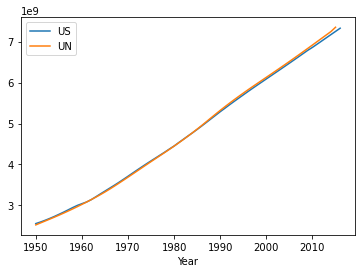

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

site = "https://en.wikipedia.org/wiki/Estimates_of_historical_world_population"
# parse all tables from Wikipedia page
# use M as decimal point to allow for numbers expressed in millions to be treated as values
tables = pd.read_html(site, header=0, index_col=0, decimal='M')

# grab table with population data from 1950 - 2016
table = tables[2]

# parse growth rate info
growth = pd.read_csv("data/growth_rate.csv", header=0, index_col=0)

# rename and remove unnecessary columns
table.columns = ["US", "PRB", "UN", "Maddison", "HYDE", "Tanton", "Biraben", "M&J", "Thomlinson", "Durand", "Clark"]
table.drop(columns=["PRB", "Maddison", "HYDE", "Tanton", "Biraben", "M&J", "Thomlinson", "Durand", "Clark"], inplace=True)

# plot population growth from 1950 to 2016
table.plot()

#### Predicting Population

Using proportional growth, needs model to predict yearly change percentage

In [3]:
un = table.UN / 1e9
us = table.US / 1e9

t0 = un.index[0]
t1 = un.index[-1]
time = t1 - t0

p0 = un[t0]

# results = Series()
results = {}
results[t0] = p0
for t in range(t0, t1):
    results[t + 1] = results[t] + (results[t] * (float(growth.loc[t + 1]["Yearly Change"][:-1]) / 100))
    
s = pd.Series(results, name="Population")
s


1950    2.525149
1951    2.572622
1952    2.619186
1953    2.665808
1954    2.712726
          ...   
2012    7.090896
2013    7.175278
2014    7.259229
2015    7.343436
2016    7.427151
Name: Population, Length: 67, dtype: float64

Using quadratic growth

In [4]:
alpha = 25 / 1000
beta = -1.8 / 1000

results = {}
results[t0] = p0

t1 = 2122
for t in range(t0, t1):
    growth = alpha * results[t] + beta * results[t]**2
    results[t + 1] = results[t] + growth
    
s = pd.Series(results, name="Population")
s

1950     2.525149
1951     2.576800
1952     2.629268
1953     2.682557
1954     2.736668
          ...    
2118    13.020382
2119    13.040737
2120    13.060646
2121    13.080117
2122    13.099159
Name: Population, Length: 173, dtype: float64

(0.005615634369937977, 0.0015317165026049351)


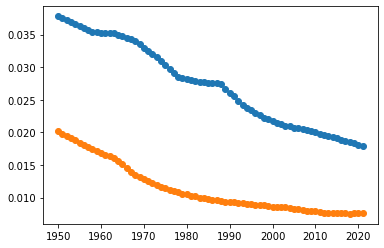

In [6]:
BrDrGraph = pd.read_csv ('data/br_dr_stats.csv')

def projectBirthsOrDeaths(year):
    x = BrDrGraph["Year"]
    yBR = BrDrGraph["BR"]
    yDR = BrDrGraph["DR"]

    plt.scatter(x, yBR)
    fit = np.polyfit(x, np.log(yBR), 1)
    slope = np.exp(fit[0])
    const = np.exp(fit[1])
    estimateBR = (slope ** year) * const

    plt.scatter(x, yDR)
    fit = np.polyfit(x, np.log(yDR), 1)
    slope = np.exp(fit[0])
    const = np.exp(fit[1])
    estimateDR = (slope ** year) * const

    return estimateBR, estimateDR

print(projectBirthsOrDeaths(2122))